In [ ]:
%pip install pandas transformers[torch] evaluate rouge_score scikit-learn datasets
%pip install accelerate -U

# Part 1: Transformers
## Task 1: BART for Text Summarization

The data was obtain from: https://data.world/crawlfeeds/the-japan-times-news-dataset-may-31-2022
It contains 3 features that we care about: the title of the article, the short description, and the
news article itself.

In [57]:
import pandas as pd
import evaluate
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import BartTokenizer, BartForConditionalGeneration, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

In [58]:
data_dir = "./the_japan_times_data_1_2022_05 copy.csv"
df = pd.read_csv(data_dir)
df.head()

,url,headline,shortDescription,siteName,author,datePublished,mainImage,breadcrumbs,newsDescription,newsRawDescription,credit,keywords,uniqId,scrapedAt
0,https://www.japantimes.co.jp/news/2022/01/02/n...,Komeito chief calls for Japan to create Asian ...,Natsuo Yamaguchi proposed that Japan take the ...,The Japan Times,Jesse Johnson,2022-01-02T17:08:49+09:00,https://cdn-japantimes.com/wp-content/uploads/...,"National,Politics","The leader of Komeito, the junior party in the...","<p>The leader of Komeito, the junior party in ...",STAFF WRITER,"China, U.S., Taiwan, U.S. military, LDP, China...",09f7fcaa-dc24-55e1-b0b2-8fcfd111f7ae,31/05/2022 08:05:56
1,https://www.japantimes.co.jp/news/2020/08/14/n...,Moon Jae-in to focus on victims in 'comfort wo...,South Korean President Moon Jae-in vowed Frida...,The Japan Times,NaN,2020-08-14T18:54:42+09:00,https://cdn-japantimes.com/wp-content/uploads/...,National,"CHEONAN, South Korea – South Korean President ...","<p><span class=""dateline"">CHEONAN, South Korea...",REUTERS,"WWII, South Korea, comfort women, South Korea-...",36268dbd-ca53-5ead-8478-84b8b3c09f8b,31/05/2022 08:05:56
2,https://www.japantimes.co.jp/news/2015/03/06/n...,Abandoned boats pose tsunami hazard at Nagoya ...,Nagoya authorities are worried that the more t...,The Japan Times,No Author,2015-03-06T16:28:09+09:00,https://cdn-japantimes.com/wp-content/uploads/...,National,Nagoya authorities are worried that the more t...,<p>Nagoya authorities are worried that the mor...,CHUNICHI SHIMBUN,"tsunami, Nagoya, ships",f72e2178-1264-532e-aed4-74fd65ff5aa4,31/05/2022 08:05:57
3,https://www.japantimes.co.jp/news/2015/06/01/w...,NSA surveillance powers lapse after no deal in...,Three U.S. spy programs aimed at stopping terr...,The Japan Times,No Author,2015-06-01T13:26:48+09:00,https://cdn-japantimes.com/wp-content/uploads/...,"Politics,World",WASHINGTON – Three U.S. spy programs aimed at ...,"<p><span class=""dateline"">WASHINGTON – </span>...",BLOOMBERG,"Barack Obama, Congress, privacy, Rand Paul, su...",afbdddc2-6de0-55a7-ac88-5ff738d0cf5c,31/05/2022 08:05:57
4,https://www.japantimes.co.jp/news/2021/06/03/b...,Mamma mia! Nintendo to open archive in Kyoto,"The facility ""where Nintendo's historical prod...",The Japan Times,NaN,2021-06-03T01:27:43+09:00,https://cdn-japantimes.com/wp-content/uploads/...,"Corporate,Business",After opening its first theme park area in Mar...,"<p>After <a href=""https://www.japantimes.co.jp...",AFP-JIJI,"Kyoto, Nintendo, museums, Super Mario, video g...",0757a539-0759-50ed-ac31-7045eda06a27,31/05/2022 08:05:57


In [59]:
# Removing unnecessary columns
df.drop(["newsRawDescription", "url", "siteName", "author", "datePublished", "mainImage", "breadcrumbs", "credit", "keywords", "uniqId", "scrapedAt"], axis=1, inplace=True)
df.head()

,headline,shortDescription,newsDescription
0,Komeito chief calls for Japan to create Asian ...,Natsuo Yamaguchi proposed that Japan take the ...,"The leader of Komeito, the junior party in the..."
1,Moon Jae-in to focus on victims in 'comfort wo...,South Korean President Moon Jae-in vowed Frida...,"CHEONAN, South Korea – South Korean President ..."
2,Abandoned boats pose tsunami hazard at Nagoya ...,Nagoya authorities are worried that the more t...,Nagoya authorities are worried that the more t...
3,NSA surveillance powers lapse after no deal in...,Three U.S. spy programs aimed at stopping terr...,WASHINGTON – Three U.S. spy programs aimed at ...
4,Mamma mia! Nintendo to open archive in Kyoto,"The facility ""where Nintendo's historical prod...",After opening its first theme park area in Mar...


In [60]:
# Checking for missing values
df.isnull().sum()

headline            0
shortDescription    0
newsDescription     0
dtype: int64

In [61]:
print(len(df))

601


In [62]:
# Removing extra text from newsDescription
extra_text = "~This could be due to a conflict with your ad-blocking or security software.~Please add japantimes.co.jp and piano.io to your list of allowed sites. ~If this does not resolve the issue or you are unable to add the domains to your allowlist, please see out this support page. ~We humbly apologize for the inconvenience."
for i in range(len(df)):
    if extra_text in df["newsDescription"][i]:
        df.loc[i, "newsDescription"] = df["newsDescription"][i].replace(extra_text, "")

In [63]:
# max length of columns
print(f"description: {df['newsDescription'].apply(lambda x: len(x)).max()}")
print(f"title: {df['headline'].apply(lambda x: len(x)).max()}")
print(f"summary: {df['shortDescription'].apply(lambda x: len(x)).max()}")

description: 15201
title: 121
summary: 265


In [64]:
# Train test split 
from datasets import Dataset
input_column = "newsDescription"
# output_column = "headline"
output_column = "shortDescription"
dataset = df[[input_column, output_column]]
dataset = Dataset.from_pandas(dataset)
dataset = dataset.train_test_split(test_size=0.1)

The code for training the BART model was adapted from: https://huggingface.co/docs/transformers/en/tasks/summarization

In [65]:
# Initalizing the model and tokenizer
model_name = "facebook/bart-large-cnn"
model = BartForConditionalGeneration.from_pretrained(model_name)
tokenizer = BartTokenizer.from_pretrained(model_name)

In [66]:
def preprocess_function(dataset):
    model_inputs = tokenizer(dataset[input_column], max_length=1024, truncation=True)
    labels = tokenizer(text_target=dataset[output_column], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Preprocessing the dataset
dataset = dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 61/61 [00:00<00:00, 1339.07 examples/s]


In [67]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [68]:
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    bleu_score = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    result["bleu"] = bleu_score["bleu"]

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [69]:
training_args = Seq2SeqTrainingArguments(
    output_dir=".ignore-ft-bart-large-cnn",
    evaluation_strategy="epoch",
    learning_rate=2e-7,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/home/tyler/miniconda3/envs/ml/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
  0%|          | 0/115 [00:00<?, ?it/s]/home/tyler/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 20%|██        | 23/115 [00:16<00:48,  1.88it/s]

{'eval_loss': 1.542628288269043, 'eval_rouge1': 0.426, 'eval_rouge2': 0.3139, 'eval_rougeL': 0.3736, 'eval_rougeLsum': 0.3761, 'eval_bleu': 0.2074, 'eval_gen_len': 66.1311, 'eval_runtime': 4.8736, 'eval_samples_per_second': 12.516, 'eval_steps_per_second': 0.616, 'epoch': 1.0}


 40%|████      | 46/115 [00:34<00:33,  2.05it/s]

{'eval_loss': 1.4988501071929932, 'eval_rouge1': 0.4298, 'eval_rouge2': 0.3188, 'eval_rougeL': 0.3761, 'eval_rougeLsum': 0.3776, 'eval_bleu': 0.2107, 'eval_gen_len': 67.5738, 'eval_runtime': 5.0644, 'eval_samples_per_second': 12.045, 'eval_steps_per_second': 0.592, 'epoch': 2.0}


 60%|██████    | 69/115 [00:50<00:22,  2.08it/s]

{'eval_loss': 1.472393274307251, 'eval_rouge1': 0.4116, 'eval_rouge2': 0.2967, 'eval_rougeL': 0.3565, 'eval_rougeLsum': 0.3579, 'eval_bleu': 0.1969, 'eval_gen_len': 68.1475, 'eval_runtime': 5.0847, 'eval_samples_per_second': 11.997, 'eval_steps_per_second': 0.59, 'epoch': 3.0}


 80%|████████  | 92/115 [01:07<00:10,  2.25it/s]

{'eval_loss': 1.4584698677062988, 'eval_rouge1': 0.4235, 'eval_rouge2': 0.3195, 'eval_rougeL': 0.3766, 'eval_rougeLsum': 0.377, 'eval_bleu': 0.2161, 'eval_gen_len': 68.623, 'eval_runtime': 5.1331, 'eval_samples_per_second': 11.884, 'eval_steps_per_second': 0.584, 'epoch': 4.0}


100%|██████████| 115/115 [01:24<00:00,  1.36it/s]

{'eval_loss': 1.45393705368042, 'eval_rouge1': 0.4222, 'eval_rouge2': 0.3184, 'eval_rougeL': 0.3752, 'eval_rougeLsum': 0.3758, 'eval_bleu': 0.2152, 'eval_gen_len': 68.9672, 'eval_runtime': 5.083, 'eval_samples_per_second': 12.001, 'eval_steps_per_second': 0.59, 'epoch': 5.0}
{'train_runtime': 84.7712, 'train_samples_per_second': 31.85, 'train_steps_per_second': 1.357, 'train_loss': 1.2301427426545517, 'epoch': 5.0}


TrainOutput(global_step=115, training_loss=1.2301427426545517, metrics={'train_runtime': 84.7712, 'train_samples_per_second': 31.85, 'train_steps_per_second': 1.357, 'train_loss': 1.2301427426545517, 'epoch': 5.0})

In [70]:
idx=10
text = dataset["test"][idx][input_column]
short_description = dataset["test"][idx][output_column]

inputs = tokenizer(text, max_length=1024, return_tensors="pt", truncation=True).input_ids
inputs = inputs.to(model.device)
outputs = model.generate(inputs, max_new_tokens=128, do_sample=False)
summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"     Article Text: {text}")
print(f"Short Description: {short_description}")
print(f"     Model Output: {summary}")

             Text: Business leaders are calling for leveraging the United Nations’ sustainable development goals to achieve global peace because the coronavirus pandemic is exacerbating social and economic inequalities not just in Japan, but worldwide.~Yoshimitsu Kobayashi, chairman of Mitsubishi Chemical Holdings Corp., said Saturday that the pandemic has forced a rethink of political and economic strategies. He called for shifting the focus of such plans from profit growth to building sustainable peace by addressing the deepening inequalities.
Short Description: United Nation's sustainable development goals said key to global peace as the coronavirus pandemic exacerbates social and economic inequalities in Japan and across the globe.
          Summary: Business leaders are calling for leveraging the United Nations’ sustainable development goals to achieve global peace. The coronavirus pandemic is exacerbating social and economic inequalities not just in Japan, but worldwide. The pand

We can see in this example, the model is able to summarize this piece of text. However, the issue that
I notice is that it copies the starting portion of the text most of the time.

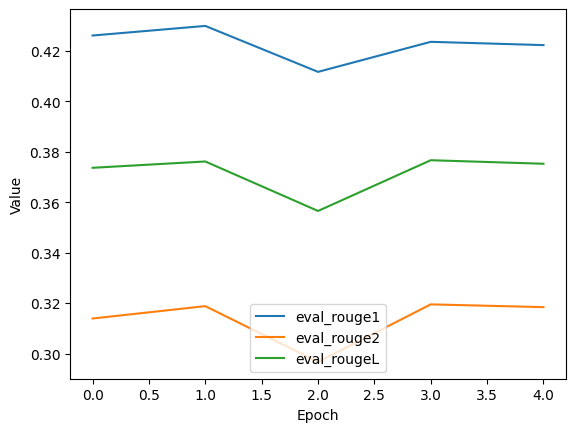

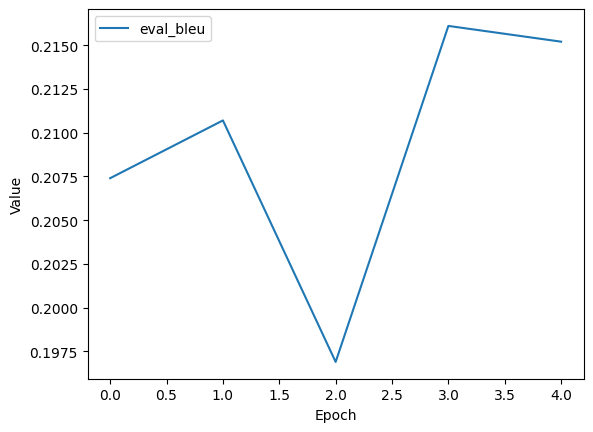

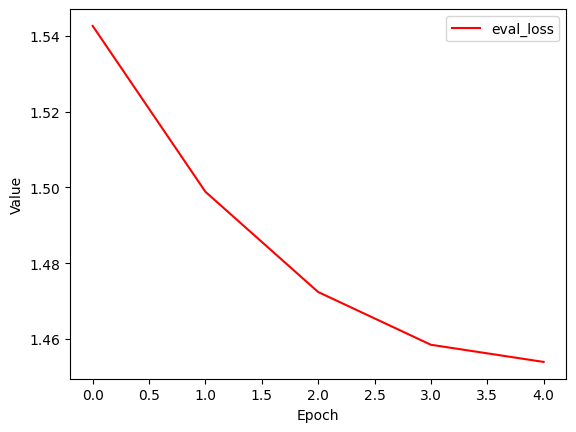

In [72]:
import matplotlib.pyplot as plt
hist = pd.DataFrame(trainer.state.log_history)

eval_loss = hist["eval_loss"].dropna()
eval_rouge1 = hist["eval_rouge1"].dropna()
eval_rouge2 = hist["eval_rouge2"].dropna()
eval_rougeL = hist["eval_rougeL"].dropna()
eval_bleu = hist["eval_bleu"].dropna()

plt.plot(eval_rouge1, label="eval_rouge1")
plt.plot(eval_rouge2, label="eval_rouge2")
plt.plot(eval_rougeL, label="eval_rougeL")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(eval_bleu, label="eval_bleu")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(eval_loss, label="eval_loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()

The bleu and rouge scores don't really change all that much even when varying the learning rate and the 
number of epochs. Even if the model's output doesn't really summarize the article the scores don't really
change either. I'm not sure why this is the case...

I think the results are impacted by the choice of LLM here. In this case BART uses both the encoder
and decoder part of the Transformer's model introduced in the Attention is All You Need paper.
In this case, the encoder part of the model is able to capture all the relationships in the
article text to be used to train the auto-regressive decoder that generates the text.
If instead we used a GPT styled model where it only contains the decoder of the Transformer model,
the model would not be able to capture the dependencies in the input text as well.

# Part 2: Reinforcement Learning
## Task 2:
A simple example of an MDP would be an animal agent (e.g. bunny) and it's environment (e.g. wilderness).
The bunny can have different states such as:
- Calm
- Hungry
- Thirsty

It can also have some actions to take such as:
- Eating grass
- Drinking water
- Roaming

The transition model would be kind of self explainatory:
- Hungry + Eating -> Calm
- Thirsty + Drinking -> Calm
- Calm + Roaming -> Thirsty or Hungry

The rewards for taking such actions would be:
- 1 for Hungry + Eating
- 1 for Thirsty + Drinking
- 0.1 for Calm + Roaming
- -0.5 for Calm + Eating or Drinking

This can help the bunny stay alive by encouraging the agent to eat and drink when it's necessary
and not stay in the same place.

## Task 3:
Humbert et al. Learning from an expert. http://www.laurentoudre.fr/publis/HADO-NIPS-16.pdf

I found an interesting paper about a form of Apprenticeship Learning where an agent
learns to mimic a human expert. Unfortunately this paper does not have open source code
to look at.
An issue that lets say a medical center does not have enough anesthesiologists
to deal with an influx of critical patients. RL can be used to mimic experts
to help alevate the burden on the human experts.

In this paper, the authors train an agent
to adminsiter anesthetic drugs given some observations about the patient
without the use of expensive and time-consuming measurements from 
electroencephalogram (EEG) signals.
They aim to use easier to measure signals such as: Heart Rate (HR),
Mean Blood Pressure (MeanBP) and Respiratory Rate (RR).
They also measure Inspired Fraction of AA (AAFi) which is used to measure
the current dosage of the anesthesia.

To solve this problem, the authors wanted to train an agent to mimic the expert
using a simple MDP to encode the problem. Given the 4 measurements from above, 
they would discretise them to obtain the state.
$$
O = (\text{HR, MeanBP, RR, AAFi})
$$
The possible actions are:
[reducing drug, nothing, add drugs].
To learn a policy, they first intialize the policy with bayesian inference
with a uniform prior (using the expert trajectories). Then, they propogate
this formation to states that were not observed with the expert trajectories
using the following similarity metric:
$$
s(O_1, O_2) = \exp (-\theta^T(|O_1-O_2|))
$$
where:
$$
\theta = (1, 1, 1, 100)
$$

This paper however, doesn't really provide that much detail to why
those chose certain values for $\theta$.

## Task 4 (6000 level):
See the `q_learning_tic-tac-toe.ipynb` for this task.